In [4]:
import tensorflow as tf
import os
exec_mode = 'GPU'
if exec_mode == 'TPU':
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
elif exec_mode == 'GPU':
  tf.debugging.set_log_device_placement(True)
  strategy = tf.distribute.MirroredStrategy()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024),
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
Virtual devices cannot be modified after being initialized


In [6]:
!pip install --upgrade kaggle==1.5.6
!chmod +x kagglesetup.sh
!./kagglesetup.sh d paultimothymooney/chest-xray-pneumonia

Requirement already up-to-date: kaggle==1.5.6 in /usr/local/lib/python3.6/dist-packages (1.5.6)
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import os
if not os.path.isdir('chest_xray'):
  !unzip chest-xray-pneumonia.zip

In [0]:
def join(base, path):
  return os.path.join(base, path)

In [0]:
import os 
path = os.path.join('chest_xray','chest_xray')
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')
val_path = os.path.join(path, 'val')


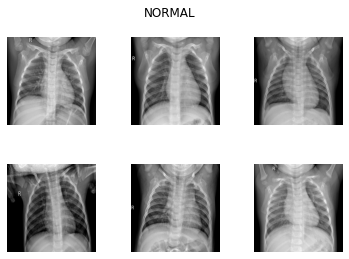

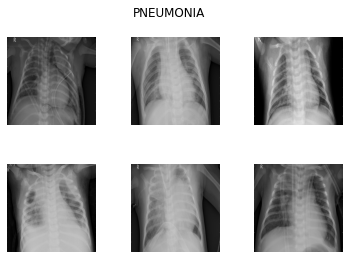

In [10]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
def visualize(path, type):
  files = os.listdir(os.path.join(path, type))
  fig, axes = plt.subplots(nrows = 2, ncols = 3)
  fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
  k = 0
  fig.suptitle(type)
  for i in range(2):
    for j in range(3):
      axes[i, j].imshow(load_img(os.path.join(os.path.join(path, type), files[k]),
                                target_size = (1000, 1000)))
      axes[i, j].axis('off')
      k += 1

visualize(train_path, 'NORMAL')
visualize(train_path, 'PNEUMONIA')



In [0]:
normal_im = join(train_path, 'NORMAL')
pneumonia_im = join(train_path, 'PNEUMONIA')

<BarContainer object of 2 artists>

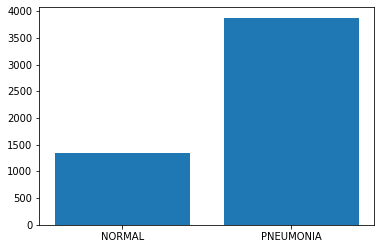

In [12]:
plt.bar(['NORMAL', 'PNEUMONIA'], [len(os.listdir(normal_im)), len(os.listdir(pneumonia_im))])

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from functools import partial 
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [0]:
import tensorflow as tf
from tensorflow.keras import optimizers



In [0]:
num_normal_im = len(os.listdir(normal_im))
num_pneumonia_im = len(os.listdir(pneumonia_im))

In [16]:
train_path


'chest_xray/chest_xray/train'

In [17]:
import glob
list_ds = tf.data.Dataset.list_files(glob.glob(train_path + "/*/*.jpeg"))
for f in list_ds.take(5):
  print(f.numpy())

Executing op MatchingFiles in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Greater in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReduceJoin in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Maximum in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousRandomSeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job

In [0]:
import numpy as np
IMG_WIDTH = 224
IMG_HEIGHT = 224
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
STEPS_PER_EPOCH = np.ceil((num_normal_im + num_pneumonia_im)/BATCH_SIZE)

In [0]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  label = 0 if parts[-2] == 'NORMAL' else 1
  return label

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, (tf.float32))
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label


In [33]:
for k in list_ds.take(1):
  my_img = k.numpy()

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [0]:
str(my_img)


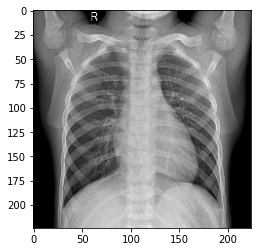

In [43]:
my_img_dec = tf.io.read_file(my_img)
my_img_dec = tf.image.decode_jpeg(my_img_dec, channels = 3)
img = tf.image.convert_image_dtype(my_img_dec, (tf.float32))
img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
plt.imshow(img)

In [49]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [50]:
for image, label in labeled_ds.take(2):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Image shape:  (224, 224, 3)
Label:  1
Image shape:  (224, 224, 3)
Label:  1


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000, prefetch = False):
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  if prefetch:
    ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [23]:
num_normal_im

1342

In [80]:
val_ds = labeled_ds.take(100)
train_ds = prepare_for_training(labeled_ds.skip(100))

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SkipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


In [83]:
val_ds = val_ds.batch(BATCH_SIZE)

Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


In [74]:
val_list = tf.data.Dataset.list_files(glob.glob(val_path + "/*/*.jpeg"))
labeled_val_ds = val_list.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds = labeled_val_ds.batch(BATCH_SIZE)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


In [75]:
image, _ = next(iter(train_ds))
# plt.imshow(image.numpy()[0])

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [0]:
def show_batch(image_batch, label_batch, num = 25):
  plt.figure(figsize=(10,10))
  label = ['NORMAL','PNEUMONIA']
  for n in range(num):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(label[label_batch[n]])
      plt.axis('off')
      

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


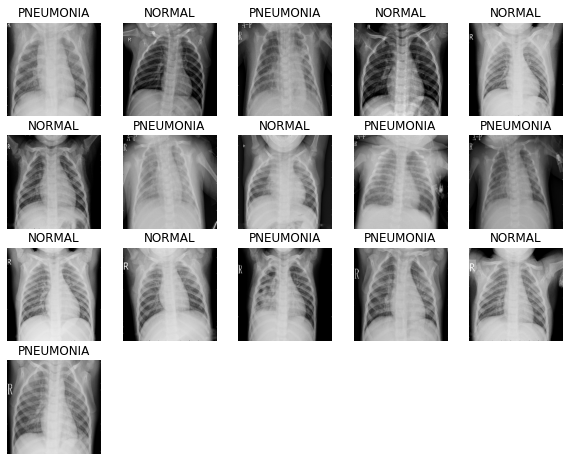

In [77]:
image_batch, label_batch = next(iter(val_ds))
show_batch(image_batch.numpy(), label_batch.numpy(), num = 16)


Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


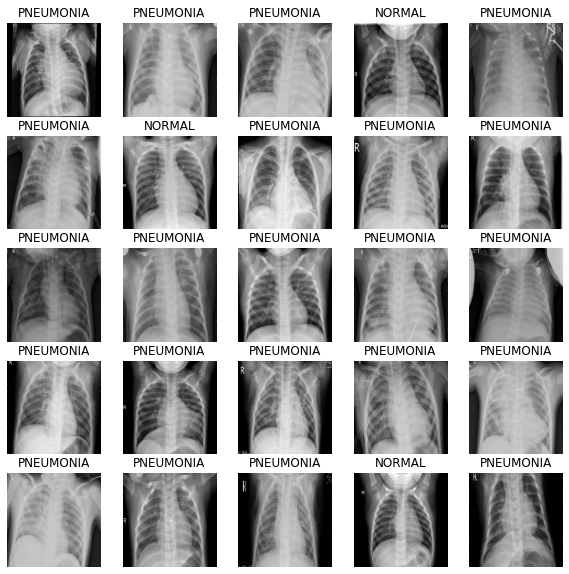

In [58]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())


In [0]:
import tensorflow as tf

def create_model():
  model = Sequential(
        [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
        ]
    )
  return model

model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = [tf.keras.metrics.Recall()])

In [84]:
history = model.fit(train_ds, validation_data = val_ds,
                    epochs = 20, steps_per_epoch = STEPS_PER_EPOCH)

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/20
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp

In [85]:
history.history.keys()

dict_keys(['loss', 'recall_1', 'val_loss', 'val_recall_1'])

No handles with labels found to put in legend.


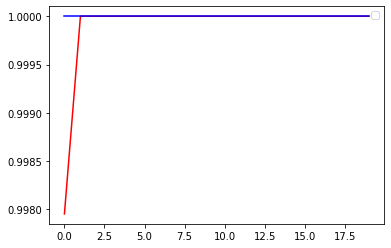

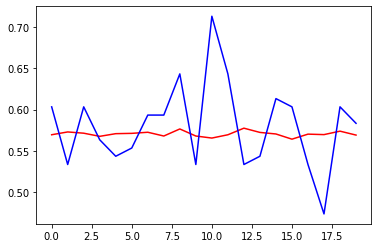

In [86]:
import matplotlib.pyplot as plt
train_acc = history.history['recall_1']
train_loss = history.history['loss']
val_acc = history.history['val_recall_1']
val_loss = history.history['val_loss']
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, color = 'red')
plt.plot(epochs, val_acc, color = 'blue')
plt.legend()
plt.figure()
plt.plot(epochs, train_loss, color = 'red')
plt.plot(epochs, val_loss, color = 'blue')